# Set up GRU Class and Helper methods

In [7]:
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time
import math

# This code was taken and partially modified from https://www.kaggle.com/rodsaldanha/stock-prediction-pytorch
# It helped us with setting up the Gated Recurrent Unit and splitting the training data, since this was not taught in lectures

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

def split_data(stock, batch_size):
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - batch_size):
        data.append(data_raw[index: index + batch_size])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return (train_set_size, [x_train, x_test, y_train, y_test])

def convert_to_tensor(np_arr):
    return torch.from_numpy(np_arr).type(torch.Tensor)


def denormalize(tensor, name): 
    return pd.DataFrame(scaler.inverse_transform(tensor.detach().numpy()), columns=[name]) # Convert normalized data back into prices

def results_to_csv(pred, actual, rmse):
    pred_and_actual = pd.concat([pred, actual], axis=1, join='outer')
    file_name = f'./NN_results/{ticker}_NN_results.xlsx'
    pred_and_actual.to_excel(file_name, sheet_name=f'{ticker}')

    with pd.ExcelWriter(file_name, mode = 'a') as writer:
        rmse = pd.Series([rmse], name='RMSE')
        rmse.to_excel(writer, sheet_name=f'{ticker} RMSE')

def log_and_print(s, file):
    print(s)
    file.write(s + '\n')


# Training 

We are going to run our neural network on a single stock and observe the Mean Squared Error (MSE) of each epoch. With this and the Root Mean Squared Error (RMSE) of the neural net's predictions on the testing data, we will adjust our hyperparameters. 

[*********************100%***********************]  1 of 1 completed
Epoch 0 MSE: 0.1539555937051773
Epoch 1 MSE: 22.902515411376953
Epoch 2 MSE: 36.55051803588867
Epoch 3 MSE: 1.396482229232788
Epoch 4 MSE: 1.934454321861267
Epoch 5 MSE: 6.501574516296387
Epoch 6 MSE: 0.3718830645084381
Epoch 7 MSE: 0.33353689312934875
Epoch 8 MSE: 1.129309892654419
Epoch 9 MSE: 0.4541189670562744
Epoch 10 MSE: 0.4466418921947479
Epoch 11 MSE: 0.42839834094047546
Epoch 12 MSE: 0.20452803373336792
Epoch 13 MSE: 0.132694810628891
Epoch 14 MSE: 0.26511120796203613
Epoch 15 MSE: 0.27861881256103516
Epoch 16 MSE: 0.1479484885931015
Epoch 17 MSE: 0.17689384520053864
Epoch 18 MSE: 0.2601637840270996
Epoch 19 MSE: 0.18351174890995026
Epoch 20 MSE: 0.12339690327644348
Epoch 21 MSE: 0.1917242407798767
Epoch 22 MSE: 0.208522766828537
Epoch 23 MSE: 0.13611894845962524
Epoch 24 MSE: 0.13822044432163239
Epoch 25 MSE: 0.1889750361442566
Epoch 26 MSE: 0.15894533693790436
Epoch 27 MSE: 0.12242791801691055
Epoch 28 MSE

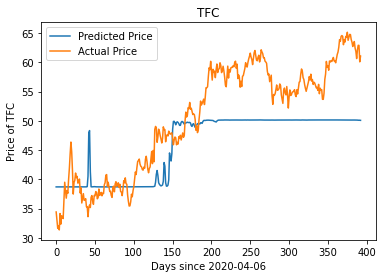

<Figure size 432x288 with 0 Axes>

In [8]:
tickers = ['TFC']

period = {
    'start': datetime.datetime(2014, 1, 3),
    'end': datetime.datetime(2021, 12, 1)
}

# Neural Net Layers
input_dim=1
hidden_dim=128
num_layers=3
output_dim=1

# Hyper Parameters
learning_rate=0.1
batch_size=25
num_epochs=100


for ticker in tickers:
    logs = open(f'./NN_results/{ticker}_logs.txt', 'a')

    prices = yf.download(ticker, **period)[['Close']].dropna()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_prices = scaler.fit_transform(prices['Close'].values.reshape(-1,1))

    test_start_date, data = split_data(normalized_prices, batch_size)

    starting_date = str(prices.iloc[test_start_date:].index[0])[:10]

    x_train, x_test, y_train_gru, y_test_gru = [*map(convert_to_tensor, data)]

    model = GRU(input_dim, hidden_dim, num_layers, output_dim)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()

    for epoch in range(num_epochs):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train_gru)
        log_and_print(f"Epoch {epoch} MSE: {loss.item()}", logs)

        optimiser.zero_grad() # Zero the tensor gradients
        loss.backward() # Calculate the gradient used in gradient descent
        optimiser.step() # Take one step in the opposite direction of the gradient

    training_time = time.time()-start_time
    log_and_print(f"Training time: {training_time}", logs)

    y_test_pred = model(x_test)

    denormalized_pred = denormalize(y_test_pred, 'Predicted')
    denormalized_test = denormalize(y_test_gru, 'Actual')


    log_and_print('\n################## STATISTICS ##################', logs)
    score = math.sqrt(mean_squared_error(denormalized_pred, denormalized_test))
    log_and_print(f'Root Mean Squared Error (RMSE) of {ticker} Neural Net: ${score:.2f}', logs)

    price_on_last_day_df: pd.Series = prices.loc[period['end'] - datetime.timedelta(days=1)]
    price_on_last_day = price_on_last_day_df.values[0]

    log_and_print(f'\n{ticker} price as of {starting_date}: ${price_on_last_day:.2f}', logs)
    log_and_print(f'RMSE relative to price as of {str(period["end"])[:10]}: {score:.2f}/{price_on_last_day:.2f} = {score/price_on_last_day*100:.2f}%\n', logs)

    plt.plot(denormalized_pred, label="Predicted Price")
    plt.plot(denormalized_test, label="Actual Price")
    plt.ylabel(f'Price of {ticker}')
    plt.xlabel(f'Days since {starting_date}')
    plt.title(ticker)
    plt.legend()
    plt.show()

    # Clean Up
    plt.clf()
    del denormalized_pred
    del denormalized_test
    del model

# Tunings 

## Number of Epochs
Looking at the training logs, we can see that the MSE of the training begins to converge around 60 epochs, so we will lower our `num_epochs` to `60`. We can see that the MSE changes erratically, signalling that our learning rate may be too high, since it will jump over local minima of the cost function. 

## Learning Rate
We will lower our `learning_rate` hyperparameter to `0.01` so that it can better fall into a local minima of the cost function. We can see that the RMSE of the training data is  $6.92. Relative to the final price of the stock on 2021-12-01, our RMSE varies 11.67% from the stock price, which is very high. 

## Neural Network Layers
We can see that the MSE of the training data is low, signalling that we have low training error but high testing error. This is also evident by looking at the graphed results of the predictions versus the actual prices. This could be due to overfitting. We will lower the number of total neurons and layers in our hidden layers of the network. This should prevent the neural network from optimizing the cost function too much which can cause overfitting. We will change the number of hidden layers from `3` to `2` and lower the number of neurons per layer from `128` to `32`.

[*********************100%***********************]  1 of 1 completed
Epoch 0 MSE: 0.16049477458000183
Epoch 1 MSE: 0.124933622777462
Epoch 2 MSE: 0.09776502102613449
Epoch 3 MSE: 0.07048556953668594
Epoch 4 MSE: 0.05970543995499611
Epoch 5 MSE: 0.040020525455474854
Epoch 6 MSE: 0.010253846645355225
Epoch 7 MSE: 0.017134206369519234
Epoch 8 MSE: 0.02559625916182995
Epoch 9 MSE: 0.014902026392519474
Epoch 10 MSE: 0.011625301092863083
Epoch 11 MSE: 0.0073763825930655
Epoch 12 MSE: 0.006265473552048206
Epoch 13 MSE: 0.009012842550873756
Epoch 14 MSE: 0.012200725264847279
Epoch 15 MSE: 0.012460182420909405
Epoch 16 MSE: 0.009352690540254116
Epoch 17 MSE: 0.00522497808560729
Epoch 18 MSE: 0.0028651084285229445
Epoch 19 MSE: 0.0032010541763156652
Epoch 20 MSE: 0.004715082235634327
Epoch 21 MSE: 0.005453374702483416
Epoch 22 MSE: 0.00523164588958025
Epoch 23 MSE: 0.0046645584516227245
Epoch 24 MSE: 0.0036845479626208544
Epoch 25 MSE: 0.0024929861538112164
Epoch 26 MSE: 0.0019715619273483753
Ep

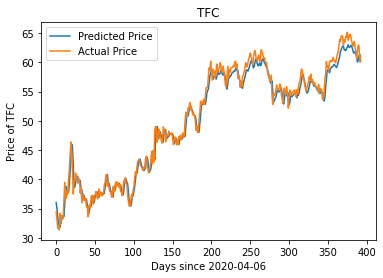

<Figure size 432x288 with 0 Axes>

In [9]:
tickers = ['TFC']

period = {
    'start': datetime.datetime(2014, 1, 3),
    'end': datetime.datetime(2021, 12, 1)
}

# Neural Net Layers
input_dim=1
hidden_dim=32
num_layers=2
output_dim=1

# Hyper Parameters
learning_rate=0.01
batch_size=25
num_epochs=60

for ticker in tickers:
    logs = open(f'./NN_results/{ticker}_logs.txt', 'a')

    prices = yf.download(ticker, **period)[['Close']].dropna()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_prices = scaler.fit_transform(prices['Close'].values.reshape(-1,1))

    test_start_date, data = split_data(normalized_prices, batch_size)

    starting_date = str(prices.iloc[test_start_date:].index[0])[:10]

    x_train, x_test, y_train_gru, y_test_gru = [*map(convert_to_tensor, data)]

    model = GRU(input_dim, hidden_dim, num_layers, output_dim)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()

    for epoch in range(num_epochs):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train_gru)
        log_and_print(f"Epoch {epoch} MSE: {loss.item()}", logs)

        optimiser.zero_grad() # Zero the tensor gradients
        loss.backward() # Calculate the gradient used in gradient descent
        optimiser.step() # Take one step in the opposite direction of the gradient

    training_time = time.time()-start_time
    log_and_print(f"Training time: {training_time}", logs)

    y_test_pred = model(x_test)

    denormalized_pred = denormalize(y_test_pred, 'Predicted')
    denormalized_test = denormalize(y_test_gru, 'Actual')


    log_and_print('\n################## STATISTICS ##################', logs)
    score = math.sqrt(mean_squared_error(denormalized_pred, denormalized_test))
    log_and_print(f'Root Mean Squared Error (RMSE) of {ticker} Neural Net: ${score:.2f}', logs)

    price_on_last_day_df: pd.Series = prices.loc[period['end'] - datetime.timedelta(days=1)]
    price_on_last_day = price_on_last_day_df.values[0]

    log_and_print(f'\n{ticker} price as of {starting_date}: ${price_on_last_day:.2f}', logs)
    log_and_print(f'RMSE relative to price as of {str(period["end"])[:10]}: {score:.2f}/{price_on_last_day:.2f} = {score/price_on_last_day*100:.2f}%\n', logs)

    plt.plot(denormalized_pred, label="Predicted Price")
    plt.plot(denormalized_test, label="Actual Price")
    plt.ylabel(f'Price of {ticker}')
    plt.xlabel(f'Days since {starting_date}')
    plt.title(ticker)
    plt.legend()
    plt.show()

    # Clean Up
    plt.clf()
    del denormalized_pred
    del denormalized_test
    del model

# Results from tuning

We can see with the tuned hyperparameters, we have lowered our final training MSE from `0.03` to `0.004`, or an improvement of ~10 times. Our RMSE of our final model on testing data is much better, falling from `$6.92` to `$1.32` or an improvement of ~5 times. Looking at the graphed results, it is obvious that the tuned model's predictions are much more accurate that our initial model's predictions. 

## Multiple Stocks

Now, we will run this on multiple stocks to prove that this type of model, a Gated Recurrent Network (GRU), works on other assets. It should be noted that since we are using a GRU, our model will have to be retrained for each stock. We will now test the GRU on stocks from different sectors including Ford, Costco, Apple, and Exxon Mobil.

[*********************100%***********************]  1 of 1 completed
Epoch 0 MSE: 0.10702045261859894
Epoch 1 MSE: 0.08684806525707245
Epoch 2 MSE: 0.041071172803640366
Epoch 3 MSE: 0.029340211302042007
Epoch 4 MSE: 0.006634719669818878
Epoch 5 MSE: 0.031143993139266968
Epoch 6 MSE: 0.014718631282448769
Epoch 7 MSE: 0.002352059818804264
Epoch 8 MSE: 0.006441120523959398
Epoch 9 MSE: 0.009684544056653976
Epoch 10 MSE: 0.010318832471966743
Epoch 11 MSE: 0.010140118189156055
Epoch 12 MSE: 0.009007207117974758
Epoch 13 MSE: 0.0062340376898646355
Epoch 14 MSE: 0.0026832041330635548
Epoch 15 MSE: 0.0012040940346196294
Epoch 16 MSE: 0.003566847648471594
Epoch 17 MSE: 0.006167825777083635
Epoch 18 MSE: 0.005154820624738932
Epoch 19 MSE: 0.002826008480042219
Epoch 20 MSE: 0.0018113360274583101
Epoch 21 MSE: 0.0018121262546628714
Epoch 22 MSE: 0.0020495248027145863
Epoch 23 MSE: 0.002414098707959056
Epoch 24 MSE: 0.0028505739755928516
Epoch 25 MSE: 0.002985262544825673
Epoch 26 MSE: 0.0024714923

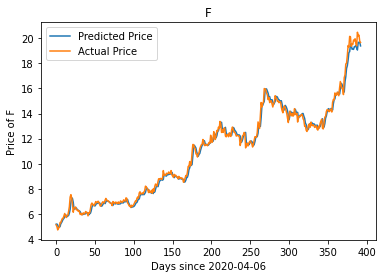

[*********************100%***********************]  1 of 1 completed
Epoch 0 MSE: 0.32412847876548767
Epoch 1 MSE: 0.09202569723129272
Epoch 2 MSE: 0.05307888612151146
Epoch 3 MSE: 0.0910121351480484
Epoch 4 MSE: 0.051092054694890976
Epoch 5 MSE: 0.03952875733375549
Epoch 6 MSE: 0.05320703983306885
Epoch 7 MSE: 0.05623938888311386
Epoch 8 MSE: 0.04432028532028198
Epoch 9 MSE: 0.030130472034215927
Epoch 10 MSE: 0.02666839398443699
Epoch 11 MSE: 0.03389227017760277
Epoch 12 MSE: 0.03310186788439751
Epoch 13 MSE: 0.021346749737858772
Epoch 14 MSE: 0.013079272583127022
Epoch 15 MSE: 0.013775029219686985
Epoch 16 MSE: 0.016071945428848267
Epoch 17 MSE: 0.011471468023955822
Epoch 18 MSE: 0.002513516927137971
Epoch 19 MSE: 0.0025997802149504423
Epoch 20 MSE: 0.010266823694109917
Epoch 21 MSE: 0.004890266805887222
Epoch 22 MSE: 0.002971108304336667
Epoch 23 MSE: 0.007289532106369734
Epoch 24 MSE: 0.005587813910096884
Epoch 25 MSE: 0.0011932667111977935
Epoch 26 MSE: 0.0006933742552064359
Epoch

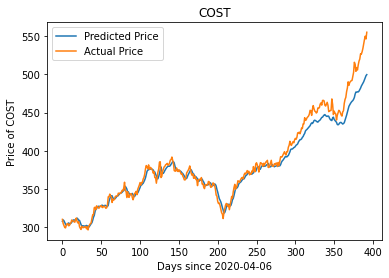

[*********************100%***********************]  1 of 1 completed
Epoch 0 MSE: 0.4495764970779419
Epoch 1 MSE: 0.1430124044418335
Epoch 2 MSE: 0.03368788957595825
Epoch 3 MSE: 0.12833333015441895
Epoch 4 MSE: 0.05236642435193062
Epoch 5 MSE: 0.026491420343518257
Epoch 6 MSE: 0.05179214850068092
Epoch 7 MSE: 0.06524322926998138
Epoch 8 MSE: 0.054962024092674255
Epoch 9 MSE: 0.035562824457883835
Epoch 10 MSE: 0.0224092286080122
Epoch 11 MSE: 0.023293185979127884
Epoch 12 MSE: 0.033146221190690994
Epoch 13 MSE: 0.03774917870759964
Epoch 14 MSE: 0.03172896057367325
Epoch 15 MSE: 0.022652333602309227
Epoch 16 MSE: 0.01841411180794239
Epoch 17 MSE: 0.020069150254130363
Epoch 18 MSE: 0.023864535614848137
Epoch 19 MSE: 0.025705838575959206
Epoch 20 MSE: 0.023848464712500572
Epoch 21 MSE: 0.01935616135597229
Epoch 22 MSE: 0.015054069459438324
Epoch 23 MSE: 0.013555620796978474
Epoch 24 MSE: 0.015041138045489788
Epoch 25 MSE: 0.0166360791772604
Epoch 26 MSE: 0.015309114009141922
Epoch 27 MSE:

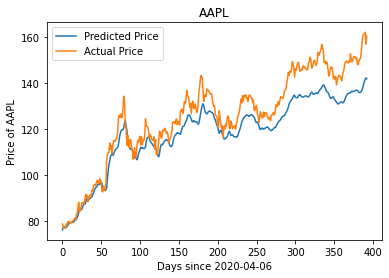

[*********************100%***********************]  1 of 1 completed
Epoch 0 MSE: 0.21942055225372314
Epoch 1 MSE: 0.09500234574079514
Epoch 2 MSE: 0.1280689388513565
Epoch 3 MSE: 0.09992790967226028
Epoch 4 MSE: 0.07452121376991272
Epoch 5 MSE: 0.07016318291425705
Epoch 6 MSE: 0.07041127234697342
Epoch 7 MSE: 0.0638660341501236
Epoch 8 MSE: 0.04972732067108154
Epoch 9 MSE: 0.03403840586543083
Epoch 10 MSE: 0.026013657450675964
Epoch 11 MSE: 0.025071196258068085
Epoch 12 MSE: 0.014293561689555645
Epoch 13 MSE: 0.002284548943862319
Epoch 14 MSE: 0.010081382468342781
Epoch 15 MSE: 0.017981523647904396
Epoch 16 MSE: 0.010497014038264751
Epoch 17 MSE: 0.007346810773015022
Epoch 18 MSE: 0.008091581985354424
Epoch 19 MSE: 0.004532251041382551
Epoch 20 MSE: 0.0020888785365968943
Epoch 21 MSE: 0.003545895917341113
Epoch 22 MSE: 0.006042919121682644
Epoch 23 MSE: 0.006962832994759083
Epoch 24 MSE: 0.006018918473273516
Epoch 25 MSE: 0.0044859847985208035
Epoch 26 MSE: 0.0037469249218702316
Epoch

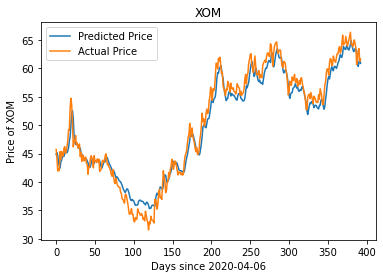

<Figure size 432x288 with 0 Axes>

In [11]:
tickers = ['F', 'COST', 'AAPL', 'XOM']

period = {
    'start': datetime.datetime(2014, 1, 3),
    'end': datetime.datetime(2021, 12, 1)
}

# Neural Net Layers
input_dim=1
hidden_dim=32
num_layers=2
output_dim=1

# Hyper Parameters
learning_rate=0.01
batch_size=25
num_epochs=60


for ticker in tickers:
    logs = open(f'./NN_results/{ticker}_logs.txt', 'a')

    prices = yf.download(ticker, **period)[['Close']].dropna()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_prices = scaler.fit_transform(prices['Close'].values.reshape(-1,1))

    test_start_date, data = split_data(normalized_prices, batch_size)

    starting_date = str(prices.iloc[test_start_date:].index[0])[:10]

    x_train, x_test, y_train_gru, y_test_gru = [*map(convert_to_tensor, data)]

    model = GRU(input_dim, hidden_dim, num_layers, output_dim)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()

    for epoch in range(num_epochs):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train_gru)
        log_and_print(f"Epoch {epoch} MSE: {loss.item()}", logs)

        optimiser.zero_grad() # Zero the tensor gradients
        loss.backward() # Calculate the gradient used in gradient descent
        optimiser.step() # Take one step in the opposite direction of the gradient

    training_time = time.time()-start_time
    log_and_print(f"Training time: {training_time}", logs)

    y_test_pred = model(x_test)

    denormalized_pred = denormalize(y_test_pred, 'Predicted')
    denormalized_test = denormalize(y_test_gru, 'Actual')


    log_and_print('\n################## STATISTICS ##################', logs)
    score = math.sqrt(mean_squared_error(denormalized_pred, denormalized_test))
    log_and_print(f'Root Mean Squared Error (RMSE) of {ticker} Neural Net: ${score:.2f}', logs)

    price_on_last_day_df: pd.Series = prices.loc[period['end'] - datetime.timedelta(days=1)]
    price_on_last_day = price_on_last_day_df.values[0]

    log_and_print(f'\n{ticker} price as of {starting_date}: ${price_on_last_day:.2f}', logs)
    log_and_print(f'RMSE relative to price as of {str(period["end"])[:10]}: {score:.2f}/{price_on_last_day:.2f} = {score/price_on_last_day*100:.2f}%\n', logs)

    plt.plot(denormalized_pred, label="Predicted Price")
    plt.plot(denormalized_test, label="Actual Price")
    plt.ylabel(f'Price of {ticker}')
    plt.xlabel(f'Days since {starting_date}')
    plt.title(ticker)
    plt.legend()
    plt.show()

    # Clean Up
    plt.clf()
    del denormalized_pred
    del denormalized_test
    del model

# Conclusion

We can see that while the model isn't perfect, it does predict prices accurately for some stocks. F had a RMSE of `$0.34`. This means our model's predictions for the price of Ford were only off by `$0.34`, on average. While the results for the other stocks were not as promising as Ford, they were not terrible. Ford proves that there exists stocks which can be accurately predicted by a GRU. As with our multi-factor linear regression model, we can see that the model's only have significant predictive power for a small subset of stocks. With enough searching, it may be possible to discover a portfolio that could be accurately predicted using GRU neural nets and multi-factor linear regression models. Further work on this topic would likely include improving on hyper parameter tuning and looking into other neural network models that could accurately predict stock prices. While we only used historical stock prices as features for our GRU model, there may exist models that could predict stock price more accurately by encoding additional features. 